### Ground Truth Translations
#### Exploration and Accuracy Calculation
w266 Final Project: Crosslingual Word Embeddings
Created: 2017-12-10 RLH
Updated: 2017-12-12 RLH


In this notebook I'm exploring the format of the ground-truth translations from MUSE (linked in BaselineModels/data) and writing a function to take the embeddings for a particular language and calculate accuracy, as defined in Vulic and Moens (2015).

In [20]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os
import sys  
import math
import random
import sklearn
import numpy as np
import pandas as pd
import collections
import datetime as dt
import matplotlib
import matplotlib.pyplot as plt
import tensorflow as tf

# tell matplotlib not to open a new window
%matplotlib inline

In [8]:
# filepaths
BASE = '/home/rhopper/W266-Fall-2017-Final-Project/BaselineModels/data/ground_truth_translations'
FPATH_ENES = BASE + '/en-es.txt' # English -> Spanish
FPATH_ENIT = BASE + '/en-it.txt' # English -> Italian
FPATH_ENNL = BASE + '/en-nl.txt' # English -> Dutch
FPATH_ESEN = BASE + '/es-en.txt' 
FPATH_ITEN = BASE + '/it-en.txt' 
FPATH_NLEN = BASE + '/nl-en.txt'

In [18]:
# We'll explore the English to Spanish file to get a feel for it
en_es = pd.read_csv(FPATH_ENES, sep=" ", header=None)
en_es.columns = ["en", "es"]
en_es.describe()

,en,es
count,112579,112579
unique,93083,96614
top,sing,angustia
freq,6,6


It seems like the idea of "ground truth" is complicated by the fact that some words have multiple equally-valid translations (e.g. "the").

I assume that in terms of accuracy, it counts as "accurate" if "the" is translated into any of the possible translations (in the context of this task).

In [24]:
en_es.head()

,en,es
0,the,el
1,the,las
2,the,los
3,the,la
4,and,y


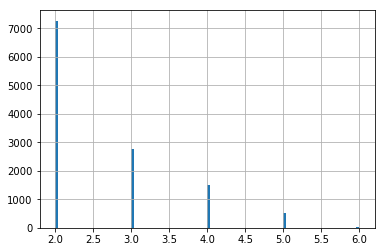

In [27]:
#How many words have more than one translation?
en_translation_counts = en_es.groupby(by='en').size()
en_translation_counts[en_translation_counts > 1].hist(bins=100)

It looks like these ground-truth translations also contain some odd values (like hex codes and text speak - "lmfao" appears).